# Crop box region in real images

In [509]:
import os
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [508]:
root_folder = "/media/ubuntu/Data/dataset/recycle/all_split/real_dataset/train/"
paths = ["ChaiBinh/20180103075742189.jpg", "ChaiBinh/20171223005356538.jpg", "ChaiBinh/20171222093344853.jpg", 
         "ChaiBinh/20171227073328650.jpg", "ChaiBinh/20171222073625702.jpg", "ChaiBinh/20171222081213145.jpg",
         "TuiNilon/20171222174335207.jpg", "TuiNilon/20171229074552452.jpg"]

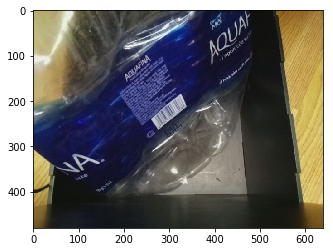

In [514]:
tmp_imagepath = "/media/ubuntu/Data/dataset/recycle/all_split/real_dataset/train/ChaiBinh/20171222093344853.jpg"

image = cv2.imread(tmp_imagepath)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Canny edge detection

In [333]:
def gaussian_blur(img, ksize=3):
    """Blue grayscale image with Gaussian kernel."""
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

In [334]:
def abs_sobel_thresh(img, orient, sobel_kernel=3, threshold=(0, 255)):
    """Absolute sobel with thresholding."""
    dx = orient == 'x'
    dy = orient == 'y'
    abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, dx, dy, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    return binary_output

In [101]:
def hough_lines(img, rho, theta, threshold, min_length, max_gap):
    """Find lines with Hough transform on binary image."""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, 
                            minLineLength=min_length, maxLineGap=max_gap)
    return lines

In [134]:
def line_inside(lines, min_x, max_x):
    """Find all lines lie inside a rectangle."""
    return ((lines >= min_x)[:, :, 0] & (lines <= max_x)[:, :, 2]).reshape((-1))


def filter_lines(lines):
    """Filter lines that are outside of the ROI."""
    left_lines = line_inside(lines, 0, 100)
    right_lines = line_inside(lines, 500, 600)
    return lines[left_lines | right_lines, ...]

In [422]:
def filter_slopes(lines, target_slope, eps=20000.5):
    """Filter out lines with invalid slopes."""
    slopes = np.array([(line[0][3] - line[0][1]) * 1.0 / (line[0][2] - line[0][0]) 
                       for line in lines])
    valid_slopes = np.abs(slopes - target_slope) < eps
    lines = lines[valid_slopes]
    slopes = slopes[valid_slopes]
    return lines, slopes

In [537]:
def find_left_line(lines, verbose=False):
    """Find the main line from a list of surrounding lines."""
    if lines is None or not len(lines):
        return None
    
    lines, slopes = filter_slopes(lines, -6.)
    if not len(lines):
        return None

    anchor_slope = np.median(slopes[np.abs(slopes + 6) < 2.5])
    x1s = np.array([(480. - (l[0][1] - s * l[0][0])) / (s + 1e-6)
                    for s, l in zip(slopes.tolist(), lines.tolist())])
    x1s[x1s < 0] = np.inf
#     idx = np.argmin(x1s)
#     _, _, anchor_x, anchor_y = lines[idx, 0, :]
    anchor_x = np.min(x1s)
    anchor_y = 480.
#     anchor_slope = slopes[np.argmin(x1s)]
    if verbose:
        print(lines, slopes, anchor_slope, anchor_x, anchor_y, x1s)
    
    y1, y2 = 480., 0.
    offset = anchor_y - anchor_slope * anchor_x
    x1 = (y1 - offset) / anchor_slope
    x2 = (y2 - offset) / anchor_slope
    return np.array([x1, y1, x2, y2]).reshape((1, 1, 4))
    
find_left_line(lines[line_inside(lines, 0, 100), ...], verbose=True)

[[[ 56 229  65 166]]

 [[  3 285  72 229]]

 [[ 24 296  78 253]]

 [[ 42 283  96 233]]

 [[  4 336  74 364]]] [-7.         -0.8115942  -0.7962963  -0.92592593  0.4       ] -7.0 20.1428600204 480.0 [  20.14286002           inf           inf           inf  363.99909   ]


array([[[  20.14286002,  480.        ,   88.71428859,    0.        ]]])

In [538]:
def find_right_line(lines, verbose=False):
    """Find the main line from a list of surrounding lines."""
    if lines is None or not len(lines):
        return None
    
    lines, slopes = filter_slopes(lines, 5.)
    if not len(lines):
        return None
    
    anchor_slope = np.median(slopes[np.abs(slopes - 5) < 2.5])
    x2s = np.array([(480. - (l[0][1] - s * l[0][0])) / (s + 1e-6)
                    for s, l in zip(slopes.tolist(), lines.tolist())])
    x2s[x2s > 640.] = -np.inf
    anchor_x = np.max(x2s)
    anchor_y = 480.
#     anchor_slope = slopes[np.argmax(x2s)]
    if verbose:
        print(lines, anchor_slope, anchor_x, anchor_y, x2s)
    
    y1, y2 = 480., 0.
    offset = anchor_y - anchor_slope * anchor_x
    x1 = (y1 - offset) / anchor_slope
    x2 = (y2 - offset) / anchor_slope
    return np.array([x1, y1, x2, y2]).reshape((1, 1, 4))
    
find_right_line(lines[line_inside(lines, 500, 600), ...], verbose=True)

[[[560 259 576 365]]

 [[560 269 575 366]]

 [[535 129 552 237]]

 [[509 266 554 339]]

 [[535 127 553 237]]

 [[514   0 532  85]]

 [[561 258 577 365]]

 [[535 135 548 218]]] 6.38461538462 615.646928451 480.0 [ 593.358401    592.62877434  590.24990709          -inf  592.76353937
  615.64692845  594.19617283  589.03605232]


array([[[ 615.64692845,  480.        ,  540.46620556,    0.        ]]])

In [414]:
def draw_lines(lines, dst_img=None, img_shape=None):
    """Draw lines on binary image."""
    if dst_img is None:
        dst_img = np.zeros(img_shape, dtype=np.uint8)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(dst_img, (int(x1), int(y1)), (int(x2), int(y2)), 
                 color=(0, 255, 0))
    return dst_img

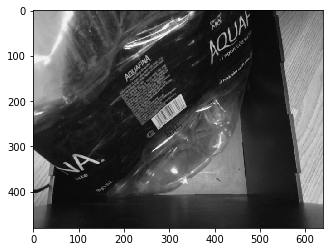

In [515]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

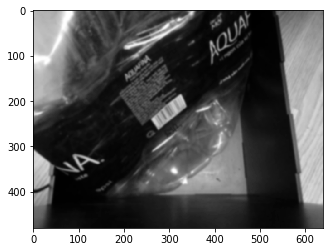

In [516]:
ksize = 9
blur = gaussian_blur(gray, ksize)
plt.imshow(blur, cmap='gray')

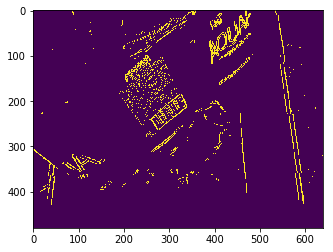

In [517]:
sobel_x = abs_sobel_thresh(blur, 'x', threshold=(50, 255))
plt.imshow(sobel_x)

In [518]:
rho = 1.0
theta = math.pi / 180
threshold = 20
min_line_len = 50.0
max_line_gap = 10.0

lines = hough_lines(sobel_x, rho, theta, threshold, min_line_len, max_line_gap)

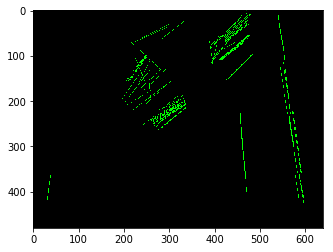

In [519]:
line_img = draw_lines(lines, img_shape=image.shape)
plt.imshow(line_img)

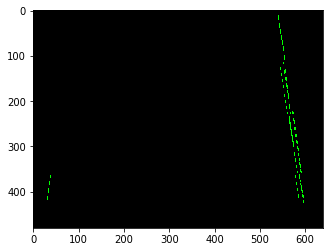

In [520]:
lines_filtered = filter_lines(lines)
line_img = draw_lines(lines_filtered, img_shape=image.shape)
plt.imshow(line_img)

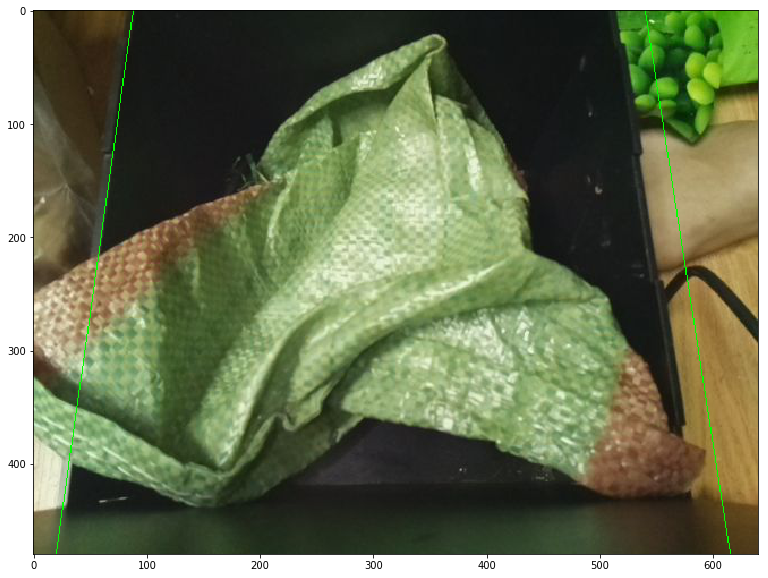

In [527]:
left_line = find_left_line(lines[line_inside(lines, 0, 100), ...])
right_line = find_right_line(lines[line_inside(lines, 500, 600), ...])
overlay_image = np.copy(image)
overlay_image = draw_lines(left_line, dst_img=overlay_image)
overlay_image = draw_lines(right_line, dst_img=overlay_image)
plt.figure(figsize=(16, 10))
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

# Run full flow

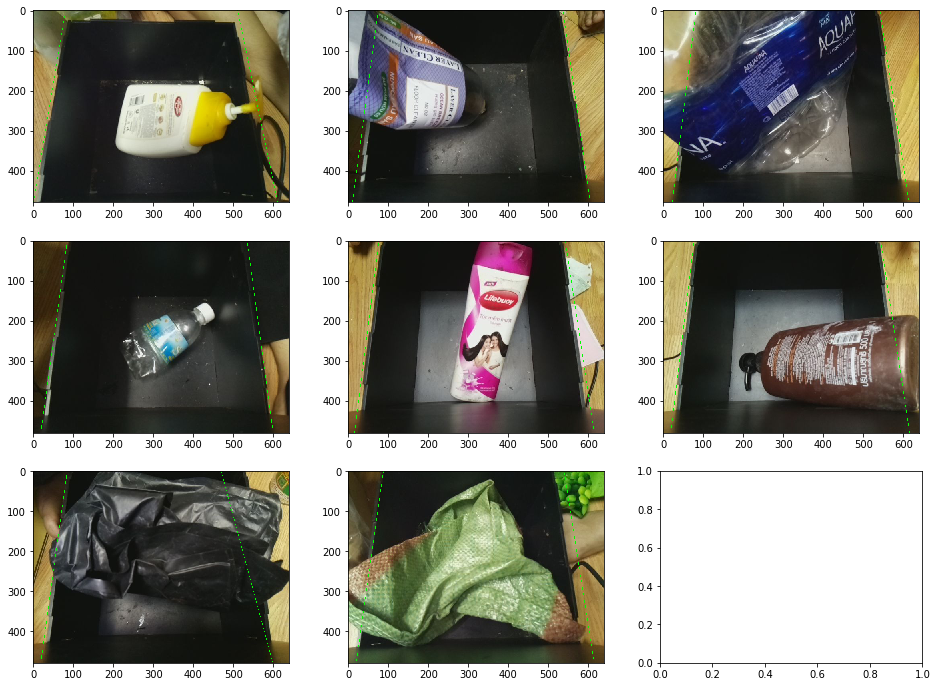

In [539]:
num_cols = 3
num_rows = (len(paths) - 1) // num_cols + 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))

for i, path in enumerate(paths):
    image = cv2.imread(os.path.join(root_folder, path))
    
    # Convert to gray to run Canny edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Blur to reduce noisy edges
    blur = gaussian_blur(gray, ksize=9)
    
    # Run sobel kernel to get edges
    sobel_x = abs_sobel_thresh(blur, 'x', threshold=(50, 255))
    
    # Get lines with Hough transform
    lines = hough_lines(sobel_x, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Filter out lines inside the box
    lines_filtered = filter_lines(lines)
    
    # Find left and right lines
    left_line = find_left_line(lines[line_inside(lines, 0, 100), ...])
    right_line = find_right_line(lines[line_inside(lines, 500, 600), ...])
    overlay_image = np.copy(image)
    overlay_image = draw_lines(left_line, dst_img=overlay_image)
    overlay_image = draw_lines(right_line, dst_img=overlay_image)
    axs[i // num_cols][i % num_cols].imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
